In [1]:
import scipy
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [2]:
path = "/Users/pineapple/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/S1/6407/Assignment/1/data"

In [3]:
train = scipy.io.loadmat(os.path.join(path, "data_train.mat"))
label = scipy.io.loadmat(os.path.join(path, "label_train.mat"))
test = scipy.io.loadmat(os.path.join(path, "data_test.mat"))

In [4]:
X_train = train['data_train']
y_train = label["label_train"]
X_test = test["data_test"]
y_train = y_train.flatten()

In [5]:
def plot_feature_distributions(X_dict, rows=2, cols=3, figsize=(9, 6)):
    """
    绘制每个类别的特征分布图。

    参数：
    X_dict (dict): 包含类别数据的字典。
    rows (int): 子图的行数。
    cols (int): 子图的列数。
    figsize (tuple): 图像大小。
    """
    for class_label, X_class in X_dict.items():
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        for i in range(X_class.shape[1]):
            row = i // cols
            col = i % cols
            sns.histplot(data=X_class[:, i], kde=True, ax=axes[row, col])
            axes[row, col].set_title(f'Feature {i+1} Distribution ({class_label})')
        for j in range(X_class.shape[1], rows * cols):
            fig.delaxes(axes[j // cols, j % cols])
        plt.tight_layout()
        plt.show()

def plot_joint_scatter(X_dict, dim, figsize=(15, 15)):
    """
    绘制每个类别的散点图和核密度估计图。

    参数：
    X_dict (dict): 包含类别数据的字典。
    dim (int): 数据的维度。
    figsize (tuple): 图像大小。
    """
    for class_label, X_class in X_dict.items():
        fig, axes = plt.subplots(dim, dim, figsize=figsize)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        for i in range(dim):
            for j in range(dim):
                if i != j:
                    sns.scatterplot(x=X_class[:, i], y=X_class[:, j], ax=axes[i, j])
                    axes[i, j].set_title(f'Scatter of {i+1} and {j+1} dim ({class_label})')
                else:
                    sns.kdeplot(x=X_class[:, i], ax=axes[i, j], fill=True)
                    axes[i, j].set_title(f'KDE of {i+1} dim ({class_label})')
        plt.show()

def visualize_correlation_matrix(X_dict):
    """
    可视化每个类别的相关性矩阵。

    参数：
    X_dict (dict): 包含类别数据的字典。
    """
    for class_label, X_class in X_dict.items():
        corr_matrix = np.corrcoef(X_class, rowvar=False)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title(f'Feature Correlation Matrix ({class_label})')
        plt.show()

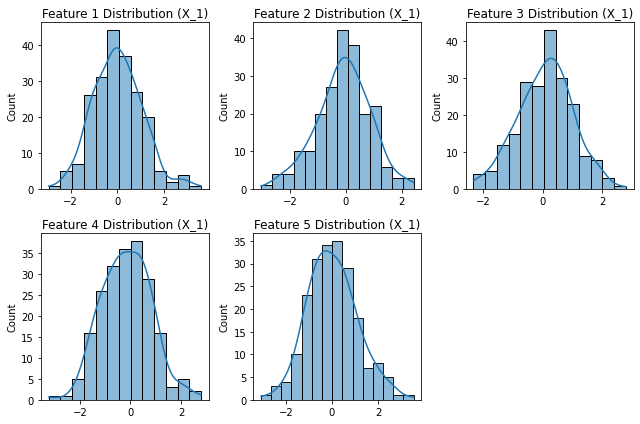

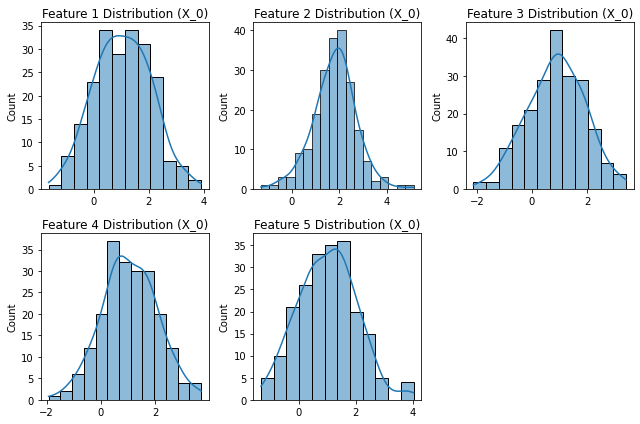

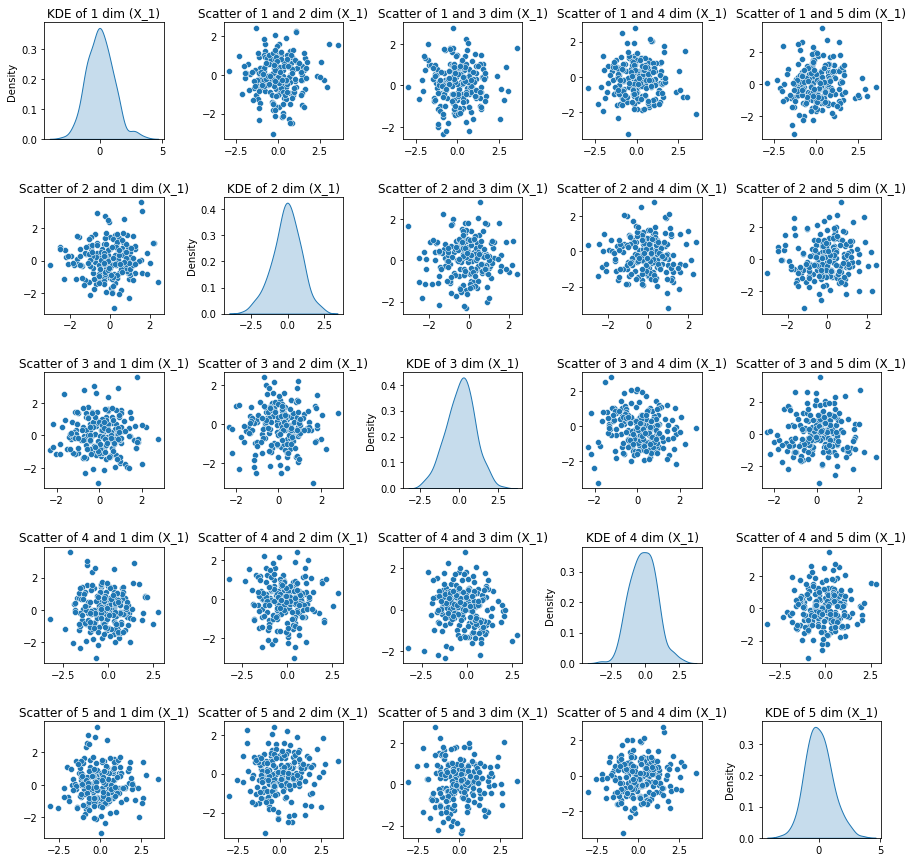

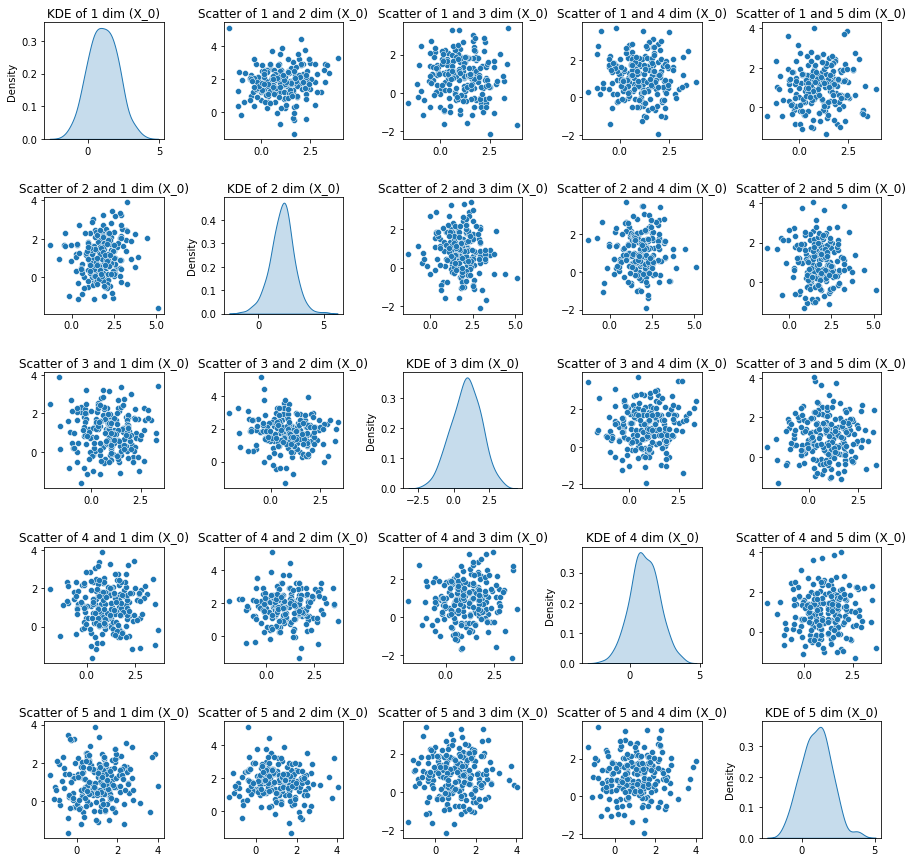

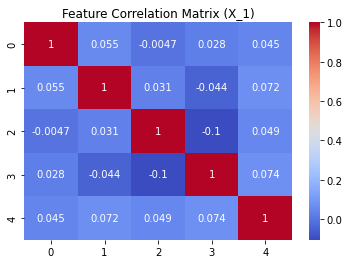

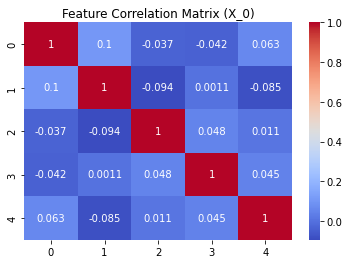

In [6]:
# 示例调用
X = {'X_1': X_train[y_train == 1], 'X_0': X_train[y_train == -1]}
plot_feature_distributions(X)
plot_joint_scatter(X, dim=X_train.shape[1])
visualize_correlation_matrix(X)

In [7]:
classes, counts = np.unique(y_train, return_counts=True)
priors = counts / len(y_train)
print(f'Classes: {classes}')
print(f'Prior probabilities: {priors}')

Classes: [-1  1]
Prior probabilities: [0.5 0.5]


In [8]:
means = []
covariances = []
for c in classes:
    X_c = X_train[y_train == c]
    means.append(np.mean(X_c, axis=0))
    covariances.append(np.cov(X_c, rowvar=False))

print(f'Means: {means}')
print(f'Covariances: {covariances}')


Means: [array([1.05170834, 1.79957542, 0.85956476, 1.06420754, 1.00855478]), array([ 0.01379514, -0.08755727,  0.08461257, -0.15482884,  0.02275036])]
Covariances: [array([[ 1.04775072e+00,  9.74443630e-02, -4.00084748e-02,
        -4.42894806e-02,  6.51321191e-02],
       [ 9.74443630e-02,  8.39017214e-01, -9.01956614e-02,
         9.91459313e-04, -7.83496197e-02],
       [-4.00084748e-02, -9.01956614e-02,  1.09720991e+00,
         5.13726225e-02,  1.12383358e-02],
       [-4.42894806e-02,  9.91459313e-04,  5.13726225e-02,
         1.03777085e+00,  4.58946940e-02],
       [ 6.51321191e-02, -7.83496197e-02,  1.12383358e-02,
         4.58946940e-02,  1.02044233e+00]]), array([[ 1.12042246,  0.05647016, -0.00456629,  0.0285    ,  0.05122562],
       [ 0.05647016,  0.93843837,  0.02756376, -0.04174351,  0.07543512],
       [-0.00456629,  0.02756376,  0.85220569, -0.09399161,  0.04922219],
       [ 0.0285    , -0.04174351, -0.09399161,  0.9464923 ,  0.07759107],
       [ 0.05122562,  0.075

In [9]:
def bayesian_decision_rule(x):
    posteriors = []
    for i, c in enumerate(classes):
        prior = priors[i]
        likelihood = multivariate_normal.pdf(x, mean=means[i], cov=covariances[i])
        posterior = prior * likelihood
        posteriors.append(posterior)
    return classes[np.argmax(posteriors)]

'''
Bayesian Decision Rule:
- Compute the prior probabilities for each class.
P(y = c) = N_c / N, where N_c is the number of samples in class c, and N is the total number of samples.
- Compute the likelihood for each class using the multivariate Gaussian distribution.
P(x | y = c) = N(x | mu_c, Sigma_c), where Sigma_c is the full covariance matrix (features are not assumed independent).
- Compute the posterior probabilities for each class using Bayes' Theorem.
P(y = c | x) = P(y = c) * P(x | y = c)
- Assign the class with the highest posterior probability.
y = argmax_c P(y = c | x)
'''



In [10]:
y_pred_bdr = np.array([bayesian_decision_rule(x) for x in X_test])

In [14]:
# 朴素贝叶斯分类器的对数概率密度计算 (每个特征独立)
def log_gaussian_pdf_naive(x, mean, covariance):
    variances = np.diag(covariance)  # 取出对角线元素，假设特征独立
    log_probs = -0.5 * ((x - mean) ** 2 / variances + np.log(2 * np.pi * variances))
    return np.sum(log_probs)  # 返回对数似然的总和

# 朴素贝叶斯分类器
def classify_naive(X_test):
    predictions = []  # 存储预测结果
    
    for x in X_test:
        log_posteriors = []  # 存储每个类别的对数后验概率
        
        for idx, c in enumerate(classes):
            # 计算对数先验概率
            log_prior = np.log(priors[idx])
            
            # 计算对数类条件概率 (每个特征独立)
            log_likelihood = log_gaussian_pdf_naive(x, means[idx], covariances[idx])
            
            # 计算对数后验概率
            log_posteriors.append(log_prior + log_likelihood)
        
        # 选择最大对数后验概率的类别
        predicted_class = np.argmax(log_posteriors)
        
        # 将类别索引映射回原始的类别标签
        predictions.append(classes[predicted_class])

    return np.array(predictions)


'''
Naive Bayes Classifier:
- Compute the prior probabilities for each class.
P(y = c) = N_c / N, where N_c is the number of samples in class c, and N is the total number of samples.
- Compute the likelihood for each feature independently assuming conditional independence.
P(x | y = c) = Π P(x_i | y = c), where each P(x_i | y = c) is a Gaussian with mean and variance specific to feature i and class c.
- Compute the posterior probabilities for each class using Bayes' Theorem.
P(y = c | x) = P(y = c) * P(x | y = c)
- Assign the class with the highest posterior probability.
y = argmax_c P(y = c | x)
'''


"\nNaive Bayes Classifier:\n- Compute the prior probabilities for each class.\nP(y = c) = N_c / N, where N_c is the number of samples in class c, and N is the total number of samples.\n- Compute the likelihood for each feature independently assuming conditional independence.\nP(x | y = c) = Π P(x_i | y = c), where each P(x_i | y = c) is a Gaussian with mean and variance specific to feature i and class c.\n- Compute the posterior probabilities for each class using Bayes' Theorem.\nP(y = c | x) = P(y = c) * P(x | y = c)\n- Assign the class with the highest posterior probability.\ny = argmax_c P(y = c | x)\n"

In [15]:
# 5. 进行预测
y_pred_nb = classify_naive(X_test)


In [16]:
y_pred_bdr = pd.DataFrame(y_pred_bdr, columns=['Bayesian Decision Rule'])
y_pred_nb = pd.DataFrame(y_pred_nb, columns=['Naive Bayes'])
y_pred = pd.concat([y_pred_bdr, y_pred_nb], axis=1)
y_pred.to_csv('/Users/pineapple/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/S1/6407/Assignment/1/result/predictions.csv', index=False)
